In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, f_regression, SelectKBest
from sklearn.linear_model import LarsCV, LinearRegression
from sklearn.metrics import mean_squared_error

In [100]:
wine_data = pd.read_csv('../data/winequality-red.csv').drop('quality', axis=1)

X, y = wine_data.iloc[:, 1:], wine_data.iloc[:, :1]

features_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# # 1️⃣ Generamos un dataset de clasificación con muchas variables (pero solo algunas relevantes)
# X, y = make_regression(n_samples=200, n_features=20, n_informative=5, random_state=42)

# features_names = ['x'+str(i) for i in range(1, X.shape[1]+1)]

# data = pd.DataFrame(X, columns=features_names)
# data["y"] = y
# # data = pd.DataFrame(np.insert(X, X.shape[1], y, 1))

# # 2️⃣ Dividimos en conjunto de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
lr_benchmark = LinearRegression()
lr_benchmark.fit(X_train, y_train)

# Evaluamos el modelo
preds = lr_benchmark.predict(X_test)
score = mean_squared_error(y_test, preds)
print(f"MSE: {score:.4f}")

MSE: 0.3416


## Filtrar por `.corr()`

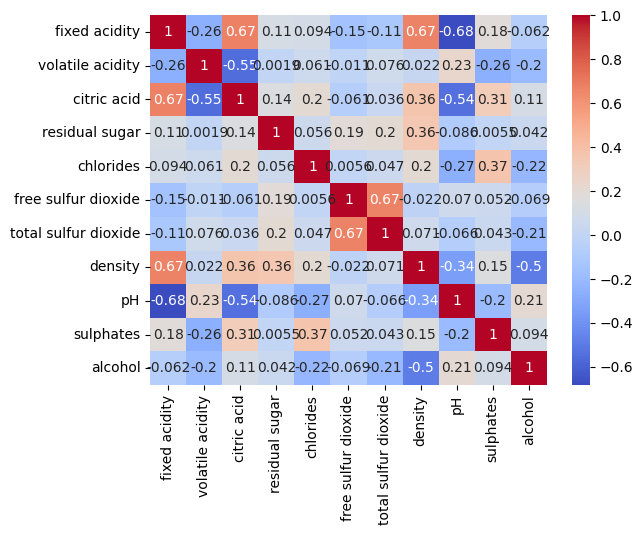

In [80]:
corr = wine_data.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [97]:
feature_selector = SelectKBest(f_regression, k=5)
X_new = feature_selector.fit_transform(X, y)

selected_cols = list(X.columns[feature_selector.get_support()])

print(f"Se seleccionaron {X_new.shape[1]} variables")
print(f"Variables seleccionadas: {selected_cols}")

lr_kbest = LinearRegression()
lr_kbest.fit(X_train[selected_cols], y_train)

# Evaluamos el modelo
preds = lr_kbest.predict(X_test[selected_cols])
score = mean_squared_error(y_test, preds)
print(f"MSE: {score:.4f}")

Se seleccionaron 5 variables
Variables seleccionadas: ['volatile acidity', 'citric acid', 'density', 'pH', 'sulphates']
MSE: 0.7028


/Users/carlos/handbook/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


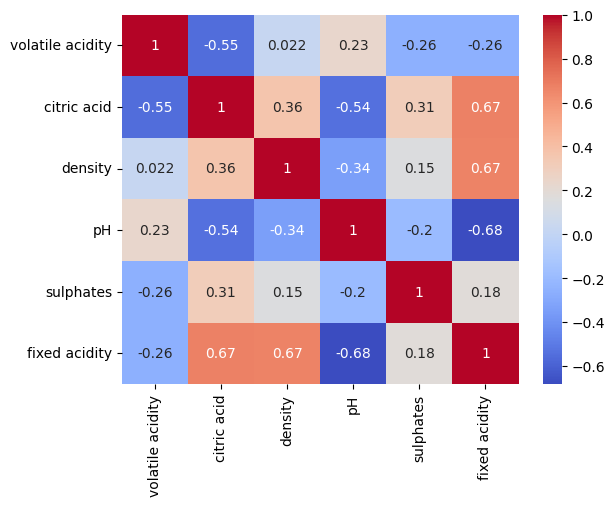

In [88]:
corr = wine_data[selected_cols + y.columns.tolist()].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## ``LarsCV``

In [110]:
np.abs(lars_cv.coef_ ) > 0.1

array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True])

In [111]:
np.where(np.abs(lars_cv.coef_ ) > 0.1)[0]

array([0, 1, 2, 3, 6, 7, 8, 9])

In [112]:
# Ajustamos el modelo LarsCV con validación cruzada
lars_cv = LarsCV(cv=5)  # 5 folds de validación cruzada
lars_cv.fit(X_train, y_train)

# Imprimimos el mejor valor de alpha encontrado
print("Mejor valor de alpha:", lars_cv.alpha_)

# Coeficientes del modelo después de la selección de variables
print("Coeficientes seleccionados por LarsCV:\n", lars_cv.coef_)

# Variables seleccionadas (donde el coeficiente no es cero)
selected_idx= np.where(np.abs(lars_cv.coef_ ) > 0.1)[0]
selected_features = np.array(features_names)[selected_idx]
print("Índices de variables seleccionadas:", selected_features)

Mejor valor de alpha: 0.0
Coeficientes seleccionados por LarsCV:
 [ 8.38077610e-01  2.73218760e+00 -2.34907013e-01 -4.79412912e+00
  1.56214945e-02 -8.84383438e-03  5.88299234e+02 -5.82694553e+00
 -6.69065114e-01  4.75855409e-01]
Índices de variables seleccionadas: ['volatile acidity' 'citric acid' 'residual sugar' 'chlorides' 'density'
 'pH' 'sulphates' 'alcohol']


/Users/carlos/handbook/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


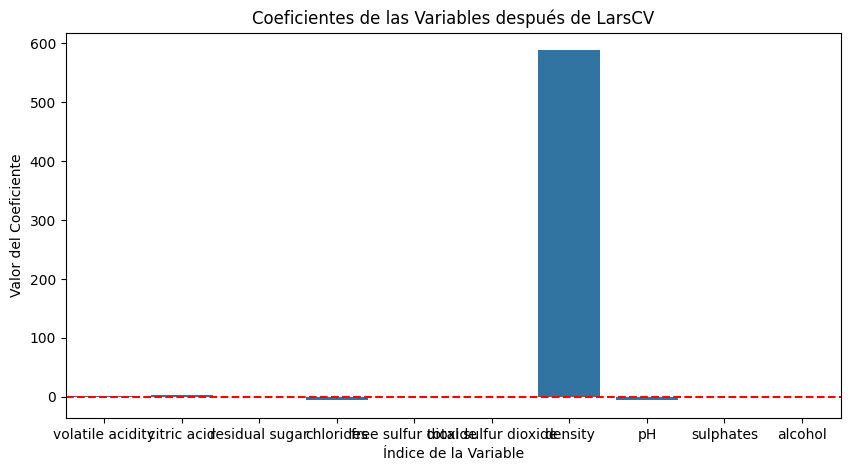

In [113]:
# Graficamos los coeficientes antes y después de la selección
plt.figure(figsize=(10,5))
sns.barplot(x=np.arange(len(lars_cv.coef_)), y=lars_cv.coef_)
plt.xlabel("Índice de la Variable")
plt.ylabel("Valor del Coeficiente")
plt.xticks(np.arange(len(lars_cv.coef_)), features_names)
plt.title("Coeficientes de las Variables después de LarsCV")
plt.axhline(0, color="red", linestyle="--")
plt.show()


In [117]:
selected_features

array(['volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
       'density', 'pH', 'sulphates', 'alcohol'], dtype='<U20')

In [118]:
# Reducimos el conjunto de datos solo a las variables seleccionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Entrenamos un nuevo modelo con las variables seleccionadas
lars_final = LarsCV(cv=5)
lars_final.fit(X_train_selected, y_train)

# Evaluamos el modelo
preds = lars_final.predict(X_test[selected_features])
score = mean_squared_error(y_test, preds)
print(f"MSE: {score:.4f}")

MSE: 0.3527


/Users/carlos/handbook/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## `RFECV`

/Users/carlos/handbook/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/carlos/handbook/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/carlos/handbook/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/carlos/handbook/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was

Número óptimo de características: 8
Índices de variables seleccionadas: [1 2 3 5 6 7 8 9]


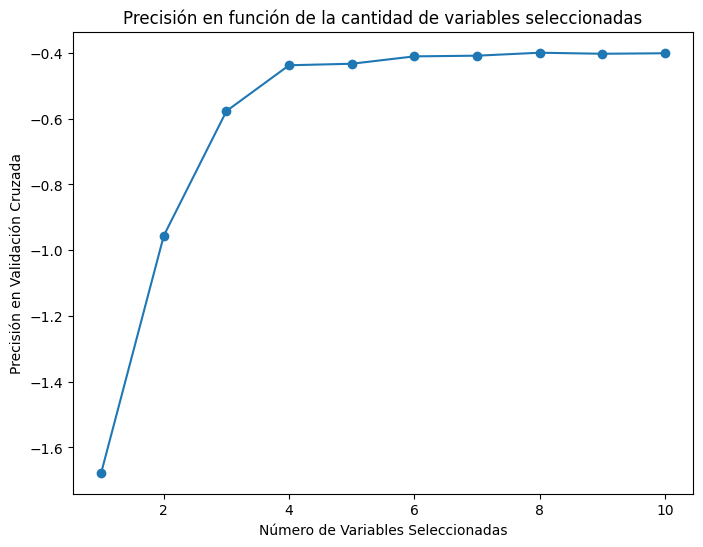

In [124]:
# 3️⃣ Creamos un modelo base (Random Forest)
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 4️⃣ Aplicamos RFECV para selección de características
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  # 5-fold CV
rfecv.fit(X_train, y_train)

# 5️⃣ Mostramos resultados
print(f"Número óptimo de características: {rfecv.n_features_}")
print(f"Índices de variables seleccionadas: {np.where(rfecv.support_)[0]}")

# 6️⃣ Visualizamos la precisión en función del número de variables
plt.figure(figsize=(8,6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Número de Variables Seleccionadas")
plt.ylabel("Precisión en Validación Cruzada")
plt.title("Precisión en función de la cantidad de variables seleccionadas")
plt.show()

In [128]:
selected_features = X.columns[rfecv.support_]

rf.fit(X_train[selected_features], y_train)

# Evaluamos el modelo
preds = rf.predict(X_test[selected_features])
score = mean_squared_error(y_test, preds)
print(f"MSE: {score:.4f}")

/Users/carlos/handbook/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE: 0.3391


In [120]:
from sklearn.metrics import get_scorer_names

get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

In [9]:
rfecv.cv_results_['mean_test_score']

array([0.56875, 0.68125, 0.75625, 0.825  , 0.8    , 0.79375, 0.8    ,
       0.79375, 0.79375, 0.825  , 0.79375, 0.8    , 0.76875, 0.80625,
       0.7875 , 0.80625, 0.78125, 0.775  , 0.8    , 0.76875])